In [1]:
import os
from sklearn.utils import shuffle
import glob
import sys
################### DATASET HANDLING ####################
DATASET_PATH = "C:\\Users\\DIC\\train_data_re" #change the path to your dataset folder here

def parseDataset():
 
    #we use subfolders as class labels
    classes = [folder for folder in sorted(os.listdir(DATASET_PATH))]
 
    #now we enlist all image paths
    images = []
    for c in classes:
        images += ([os.path.join(DATASET_PATH, c, path) for path in os.listdir(os.path.join(DATASET_PATH, c))])
    #print(images)
    #shuffle image paths
    images = shuffle(images, random_state=42)
 
    #we want to use a 15% validation split
    vsplit = int(len(images) * 0.20)
    train = images[:-vsplit]
    val = images[-vsplit:]
 
    #show some stats
    print ("CLASS LABELS:", classes)
    print ("TRAINING IMAGES:", len(train))
    print ("VALIDATION IMAGES:", len(val))
 
    return classes, train, val
 
#parse dataset
CLASSES, TRAIN, VAL = parseDataset()


CLASS LABELS: ['CEP', 'DSCT', 'ECL', 'LPV', 'RRLYR', 'T2CEP']
TRAINING IMAGES: 14348
VALIDATION IMAGES: 3587


In [2]:
import lasagne
from lasagne import layers
from lasagne.nonlinearities import softmax, tanh

In [3]:
from lasagne import layers
from lasagne.nonlinearities import softmax, tanh
 
################## BUILDING THE MODEL ###################
def buildModel():
    #this is our input layer with the inputs (None, dimensions, width, height)
    l_input = layers.InputLayer((None, 3, 22, 23))
    
    #first convolutional layer, has l_input layer as incoming and is followed by a pooling layer
    l_conv1 = layers.Conv2DLayer(l_input, num_filters=32, filter_size=3, nonlinearity=lasagne.nonlinearities.rectify)
    
    l_pool = layers.MaxPool2DLayer(l_conv1, pool_size=2)
    
    l_drop1= layers.DropoutLayer(l_pool,  p=0.1)
    
    l_dense1 = layers.DenseLayer(l_drop1, num_units=128)
    
    #l_conv2 = layers.Conv2DLayer(l_dense1, num_filters=64, filter_size=3, nonlinearity=lasagne.nonlinearities.rectify)
    
    l_dense2 = layers.DenseLayer(l_dense1, num_units=128)
    
    l_drop2= layers.DropoutLayer(l_dense2,  p=0.25)
    
    l_dense2 = layers.DenseLayer(l_drop2, num_units=256)
    
    l_output = layers.DenseLayer(l_dense2, num_units=6, nonlinearity=lasagne.nonlinearities.softmax)
    
    #let's see how many params our net has
    print ("MODEL HAS", layers.count_params(l_output), "PARAMS")
    
    #we return the layer stack as our network by returning the last layer
    return l_output


NET = buildModel()


MODEL HAS 461702 PARAMS


In [4]:
from lasagne import objectives
 
import theano
import theano.tensor as T
 
#################### LOSS FUNCTION ######################
def calc_loss(prediction, targets):
 
    #categorical crossentropy is the best choice for a multi-class softmax output
    l = T.mean(objectives.categorical_crossentropy(prediction, targets))
    
    return l
 
#theano variable for the class targets
#this is the output vector the net should predict
targets = T.matrix('targets', dtype=theano.config.floatX)
 
#get the network output
prediction = layers.get_output(NET)
 
#calculate the loss
loss = calc_loss(prediction, targets)

In [5]:
################# ACCURACY FUNCTION #####################
def calc_accuracy(prediction, targets):
 
    #we can use the lasagne objective categorical_accuracy to determine the top1 accuracy
    a = T.mean(objectives.categorical_accuracy(prediction, targets, top_k=1))
    
    return a
 
accuracy = calc_accuracy(prediction, targets)

In [6]:
from lasagne import updates
 
####################### UPDATES #########################
#get all trainable parameters (weights) of our net
params = layers.get_all_params(NET, trainable=True)
 
#we use the adam update
#it changes params based on our loss function with the learning rate
param_updates = updates.adam(loss, params, learning_rate=0.0001)

In [7]:
import theano
#################### TRAIN FUNCTION ######################
#the theano train functions takes images and class targets as input
#it updates the parameters of the net and returns the current loss as float value
#compiling theano functions may take a while, you might want to get a coffee now...
print ("COMPILING THEANO TRAIN FUNCTION...",)
train_net = theano.function([layers.get_all_layers(NET)[0].input_var, targets], loss, updates=param_updates)
print ("DONE!")
 
################# PREDICTION FUNCTION ####################
#we need the prediction function to calculate the validation accuracy
#this way we can test the net after training
#first we need to get the net output
net_output = layers.get_output(NET)
 
#now we compile another theano function; this may take a while, too
print ("COMPILING THEANO TEST FUNCTION...",)
test_net = theano.function([layers.get_all_layers(NET)[0].input_var, targets], [net_output, loss, accuracy])
print ("DONE!")

COMPILING THEANO TRAIN FUNCTION...


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


DONE!
COMPILING THEANO TEST FUNCTION...
DONE!


In [8]:
import cv2
import numpy as np
 
#################### BATCH HANDLING #####################
def loadImageAndTarget(path):
 
    #here we open the image and scale it to 64x64 pixels
    img = cv2.imread(path)
    #print(img)
    img = cv2.resize(img, (22, 23))
    
    #OpenCV uses BGR instead of RGB, but for now we can ignore that
    #our image has the shape (64, 64, 3) but we need it to be (3, 64, 64)
    #img = np.transpose(img, (2, 0, 1))
    
    #we want to use subfolders as class labels
    label = path.split(os.sep[-1])[-2]
    #print(label)
 
    #we need to get the index of our label from CLASSES
    index = CLASSES.index(label)
 
    #allocate array for target
    target = np.zeros((6), dtype='float32')
 
    #we set our target array = 1.0 at our label index, all other entries remain zero
    #Example: if label = dog and dog has index 2 in CLASSES, target looks like: [0.0, 0.0, 1.0, 0.0, 0.0]
    target[index] = 1.0
 
    #we need a 4D-vector for our image and a 2D-vector for our targets
    #we can adjust array dimension with reshape
    img = img.reshape(-1, 3, 22, 23)
    target = target.reshape(-1, 6)
 
    return img, target

In [9]:
#a reasonable size for one batch is 128
BATCH_SIZE = 200
def getDatasetChunk(split):
 
    #get batch-sized chunks of image paths
    for i in range(0, len(split), BATCH_SIZE):
        yield split[i:i+BATCH_SIZE]
        
def getNextImageBatch(split=TRAIN):    
 
    #allocate numpy arrays for image data and targets
    #input shape of our ConvNet is (None, 3, 22, 23)
    x_b = np.zeros((BATCH_SIZE, 3, 22, 23), dtype='float32')
    #output shape of our ConvNet is (None, 5) as we have 5 classes
    y_b = np.zeros((BATCH_SIZE, 6), dtype='float32')
 
    #fill batch
    for chunk in getDatasetChunk(split):        
        ib = 0
        for path in chunk:
            #load image data and class label from path
            x, y = loadImageAndTarget(path)
 
            #pack into batch array
            x_b[ib] = x
            y_b[ib] = y
            ib += 1
 
        #instead of return, we use yield
        yield x_b[:len(chunk)], y_b[:len(chunk)]

START TRAINING...
EPOCH: 1
TRAIN LOSS: 1.6737937270304508
VAL LOSS: 1.4284774286471817
VAL ACCURACY: 45.0 %
TIME: 172.2 s


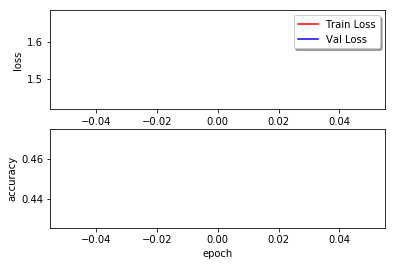

EPOCH: 2
TRAIN LOSS: 1.3295740186563871
VAL LOSS: 1.259475940201174
VAL ACCURACY: 52.3 %
TIME: 29.3 s


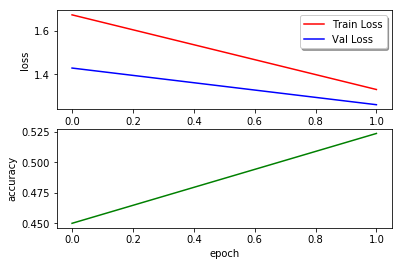

EPOCH: 3
TRAIN LOSS: 1.1900968803695324
VAL LOSS: 1.1205768156614853
VAL ACCURACY: 58.1 %
TIME: 28.8 s


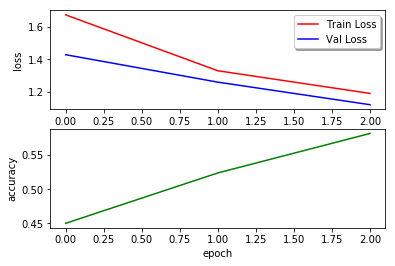

EPOCH: 4
TRAIN LOSS: 1.0640035053760484
VAL LOSS: 1.0505431475656906
VAL ACCURACY: 62.2 %
TIME: 28.0 s


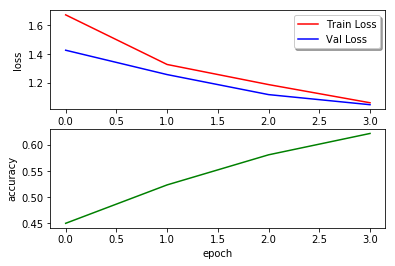

EPOCH: 5
TRAIN LOSS: 0.9916617501351206
VAL LOSS: 0.9652241234954696
VAL ACCURACY: 64.9 %
TIME: 28.0 s


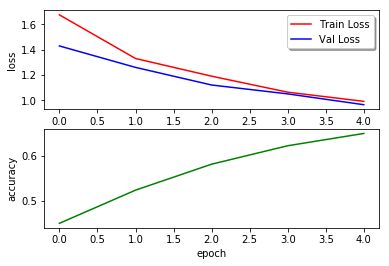

EPOCH: 6
TRAIN LOSS: 0.9328191650182048
VAL LOSS: 0.9099021571250216
VAL ACCURACY: 66.1 %
TIME: 28.4 s


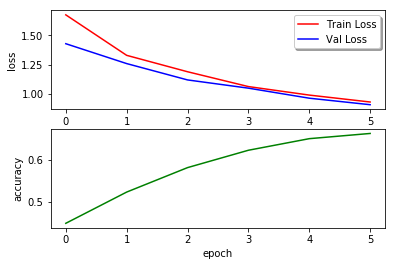

EPOCH: 7
TRAIN LOSS: 0.8844692424611873
VAL LOSS: 0.8851281869727099
VAL ACCURACY: 66.4 %
TIME: 29.0 s


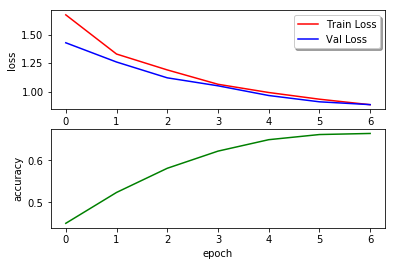

EPOCH: 8
TRAIN LOSS: 0.8524946116129047
VAL LOSS: 0.865095221994657
VAL ACCURACY: 68.6 %
TIME: 28.7 s


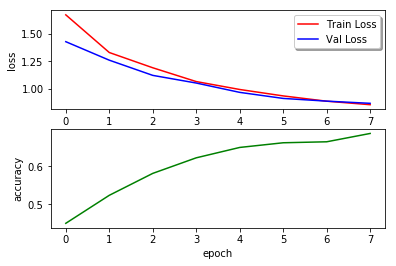

EPOCH: 9
TRAIN LOSS: 0.8194162619588492
VAL LOSS: 0.8285675030944889
VAL ACCURACY: 69.0 %
TIME: 28.3 s


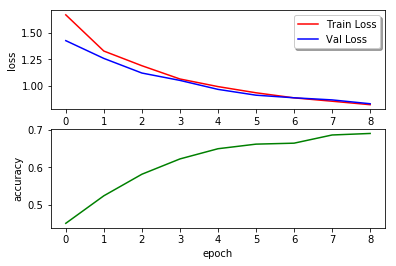

EPOCH: 10
TRAIN LOSS: 0.7918914589273627
VAL LOSS: 0.8063497276478171
VAL ACCURACY: 70.6 %
TIME: 28.4 s


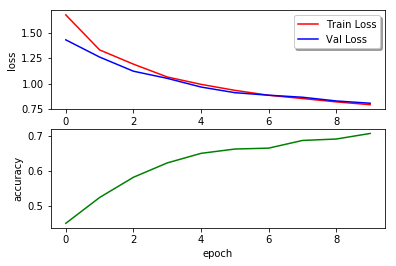

EPOCH: 11
TRAIN LOSS: 0.76298705670434
VAL LOSS: 0.7813061502901643
VAL ACCURACY: 71.6 %
TIME: 29.1 s


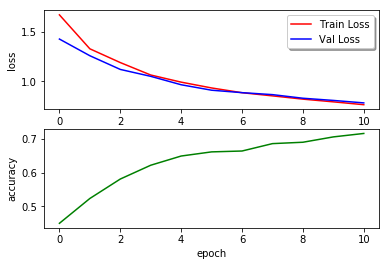

EPOCH: 12
TRAIN LOSS: 0.7511514452484003
VAL LOSS: 0.7728476199596854
VAL ACCURACY: 72.3 %
TIME: 29.2 s


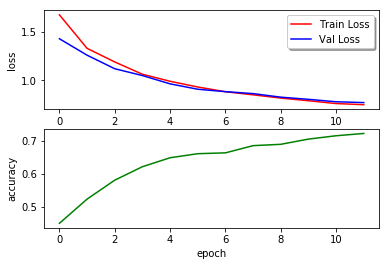

EPOCH: 13
TRAIN LOSS: 0.720013318121051
VAL LOSS: 0.7394411969660639
VAL ACCURACY: 72.5 %
TIME: 28.0 s


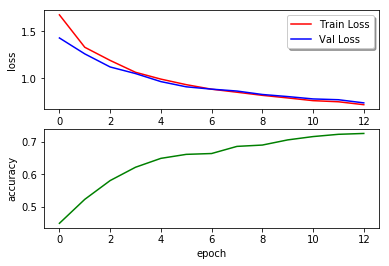

EPOCH: 14
TRAIN LOSS: 0.7025628103843068
VAL LOSS: 0.7122590862891269
VAL ACCURACY: 74.9 %
TIME: 27.9 s


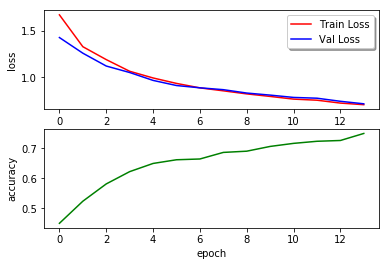

EPOCH: 15
TRAIN LOSS: 0.6847004445498449
VAL LOSS: 0.7230393701278257
VAL ACCURACY: 73.8 %
TIME: 28.8 s


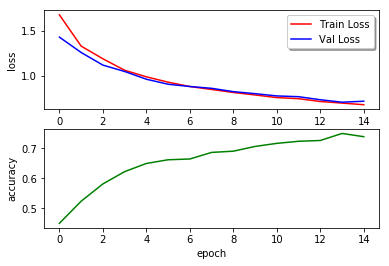

EPOCH: 16
TRAIN LOSS: 0.6706569729022421
VAL LOSS: 0.7098298398376772
VAL ACCURACY: 74.6 %
TIME: 28.6 s


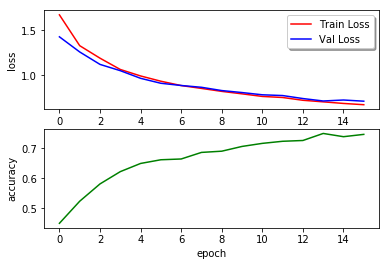

EPOCH: 17
TRAIN LOSS: 0.6554820191141104
VAL LOSS: 0.6759137722724703
VAL ACCURACY: 76.4 %
TIME: 28.7 s


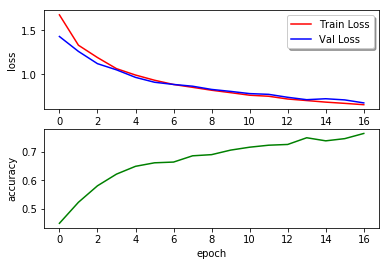

EPOCH: 18
TRAIN LOSS: 0.6428818418579739
VAL LOSS: 0.6566301916752897
VAL ACCURACY: 76.8 %
TIME: 28.3 s


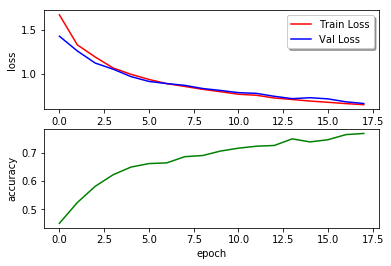

EPOCH: 19
TRAIN LOSS: 0.6231083851086817
VAL LOSS: 0.6665371341998602
VAL ACCURACY: 76.4 %
TIME: 29.2 s


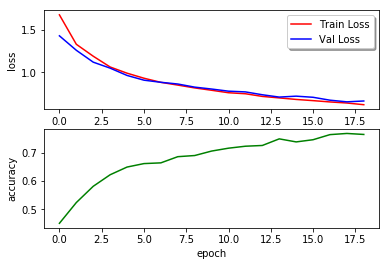

EPOCH: 20
TRAIN LOSS: 0.6234019867100417
VAL LOSS: 0.6395454179030264
VAL ACCURACY: 77.1 %
TIME: 29.1 s


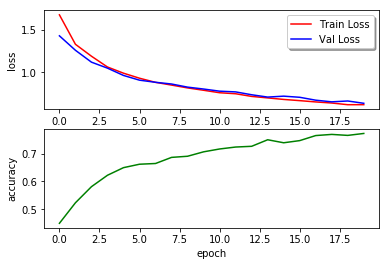

EPOCH: 21
TRAIN LOSS: 0.5979749433808847
VAL LOSS: 0.634225055762429
VAL ACCURACY: 77.2 %
TIME: 28.9 s


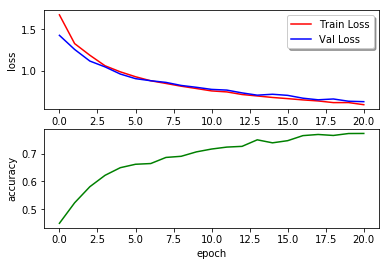

EPOCH: 22
TRAIN LOSS: 0.5913481588273289
VAL LOSS: 0.6215808206836777
VAL ACCURACY: 78.0 %
TIME: 28.3 s


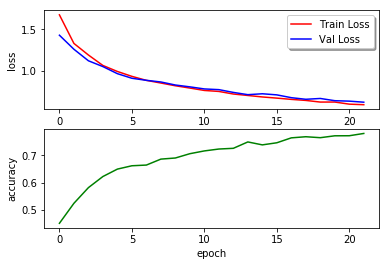

EPOCH: 23
TRAIN LOSS: 0.5757615923779649
VAL LOSS: 0.610462285041279
VAL ACCURACY: 79.2 %
TIME: 28.3 s


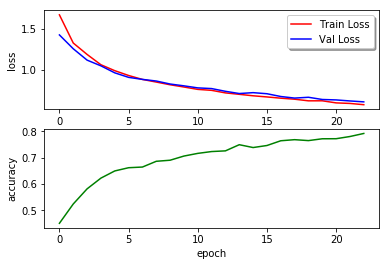

EPOCH: 24
TRAIN LOSS: 0.5765713810443169
VAL LOSS: 0.6118515380455072
VAL ACCURACY: 78.1 %
TIME: 28.5 s


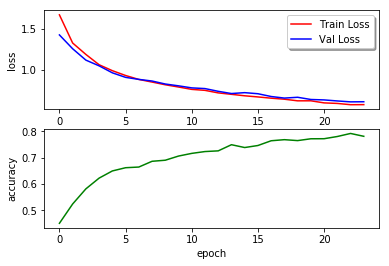

EPOCH: 25
TRAIN LOSS: 0.5590771028936136
VAL LOSS: 0.5970154415983584
VAL ACCURACY: 78.6 %
TIME: 28.6 s


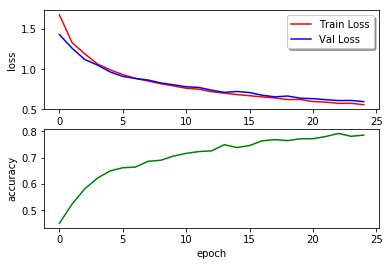

EPOCH: 26
TRAIN LOSS: 0.550615671701073
VAL LOSS: 0.5734319250026624
VAL ACCURACY: 79.5 %
TIME: 28.4 s


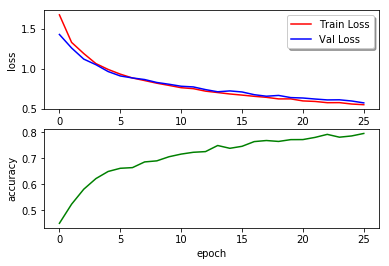

EPOCH: 27
TRAIN LOSS: 0.539154592430427
VAL LOSS: 0.5734652993717517
VAL ACCURACY: 79.2 %
TIME: 28.5 s


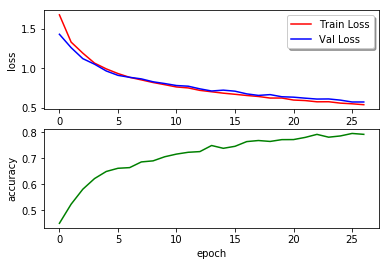

EPOCH: 28
TRAIN LOSS: 0.5347949316429409
VAL LOSS: 0.55755168363209
VAL ACCURACY: 80.2 %
TIME: 28.0 s


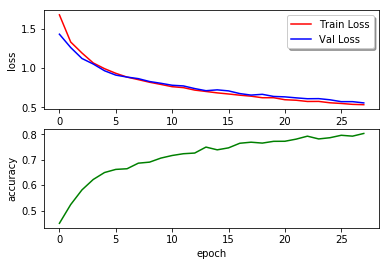

EPOCH: 29
TRAIN LOSS: 0.5210792477988425
VAL LOSS: 0.5578567853639625
VAL ACCURACY: 80.5 %
TIME: 27.8 s


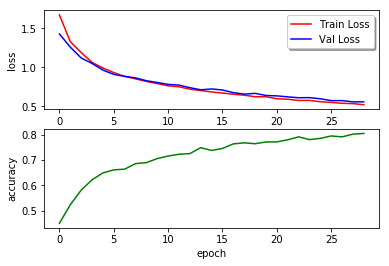

EPOCH: 30
TRAIN LOSS: 0.5161947876790687
VAL LOSS: 0.5462488073470774
VAL ACCURACY: 80.3 %
TIME: 28.4 s


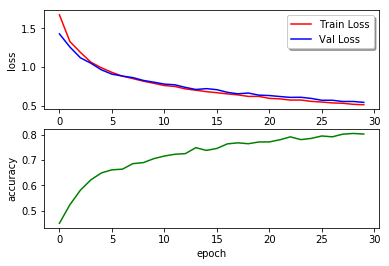

EPOCH: 31
TRAIN LOSS: 0.5069789544145712
VAL LOSS: 0.5441154887908755
VAL ACCURACY: 81.1 %
TIME: 27.9 s


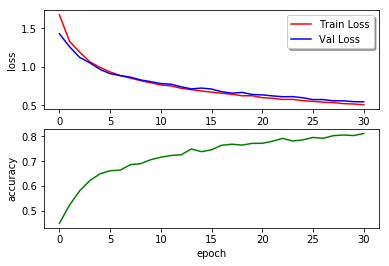

EPOCH: 32
TRAIN LOSS: 0.4945549852178536
VAL LOSS: 0.5357697003890701
VAL ACCURACY: 81.2 %
TIME: 27.9 s


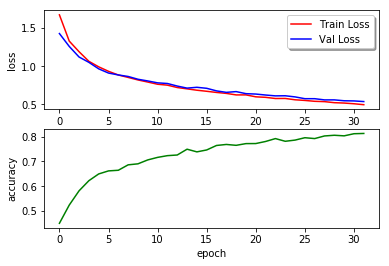

EPOCH: 33
TRAIN LOSS: 0.49124389835473853
VAL LOSS: 0.5353331136691324
VAL ACCURACY: 81.0 %
TIME: 27.7 s


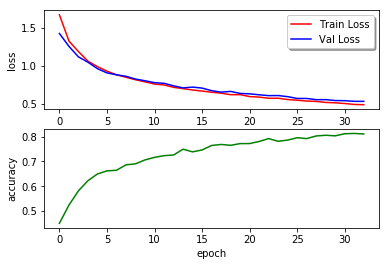

EPOCH: 34
TRAIN LOSS: 0.4875900895184778
VAL LOSS: 0.5252918003619201
VAL ACCURACY: 80.8 %
TIME: 28.1 s


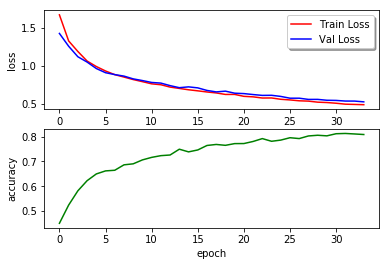

EPOCH: 35
TRAIN LOSS: 0.4761856412949734
VAL LOSS: 0.534602279021093
VAL ACCURACY: 80.5 %
TIME: 28.0 s


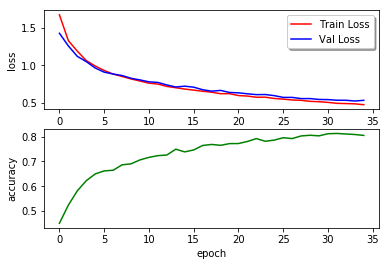

EPOCH: 36
TRAIN LOSS: 0.4718411556984863
VAL LOSS: 0.5237906390910543
VAL ACCURACY: 80.8 %
TIME: 28.1 s


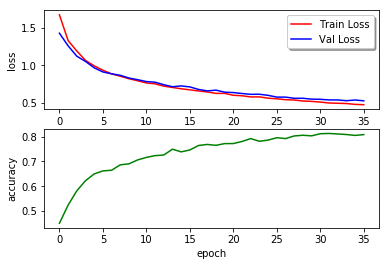

EPOCH: 37
TRAIN LOSS: 0.4652438182406074
VAL LOSS: 0.5148506093305257
VAL ACCURACY: 81.7 %
TIME: 28.3 s


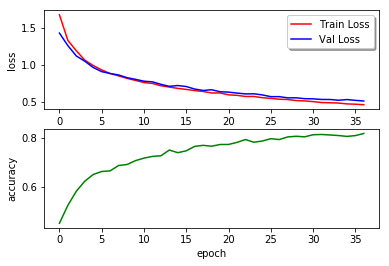

EPOCH: 38
TRAIN LOSS: 0.4569268985607072
VAL LOSS: 0.5254717079983374
VAL ACCURACY: 81.8 %
TIME: 28.2 s


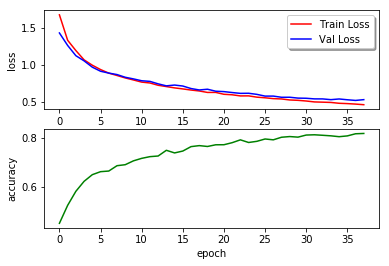

EPOCH: 39
TRAIN LOSS: 0.44939141655904014
VAL LOSS: 0.5009474154588593
VAL ACCURACY: 82.2 %
TIME: 28.1 s


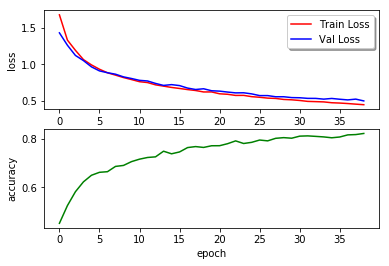

EPOCH: 40
TRAIN LOSS: 0.4464181289582025
VAL LOSS: 0.5055910402818922
VAL ACCURACY: 81.9 %
TIME: 28.7 s


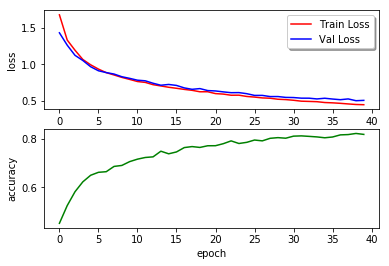

EPOCH: 41
TRAIN LOSS: 0.4448662517803281
VAL LOSS: 0.49746542695708623
VAL ACCURACY: 82.0 %
TIME: 28.1 s


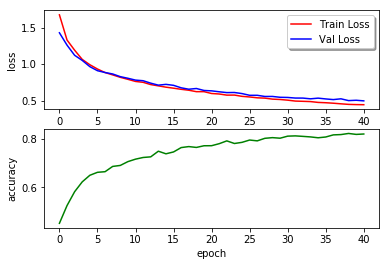

EPOCH: 42
TRAIN LOSS: 0.42913047887293715
VAL LOSS: 0.4947774137297519
VAL ACCURACY: 82.7 %
TIME: 27.8 s


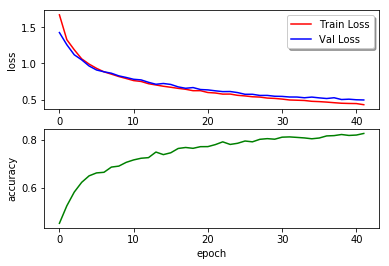

EPOCH: 43
TRAIN LOSS: 0.43228240210029967
VAL LOSS: 0.4896209704775385
VAL ACCURACY: 82.5 %
TIME: 28.2 s


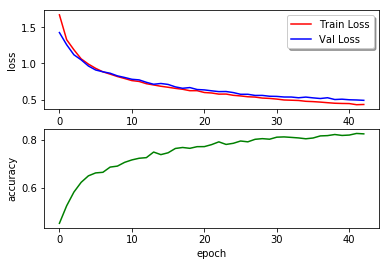

EPOCH: 44
TRAIN LOSS: 0.41996370389385734
VAL LOSS: 0.4875242358359513
VAL ACCURACY: 82.7 %
TIME: 29.5 s


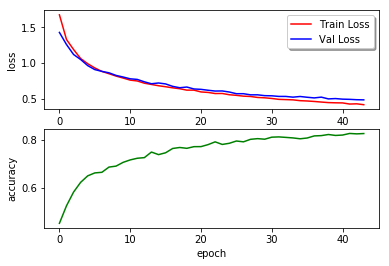

EPOCH: 45
TRAIN LOSS: 0.41817255120895647
VAL LOSS: 0.4864544581199692
VAL ACCURACY: 82.5 %
TIME: 28.2 s


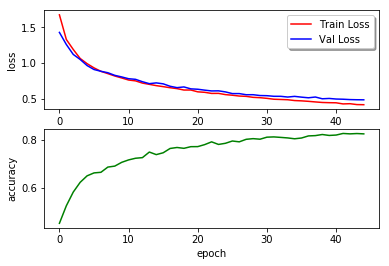

EPOCH: 46
TRAIN LOSS: 0.4094280663008218
VAL LOSS: 0.4813364610987762
VAL ACCURACY: 82.7 %
TIME: 27.5 s


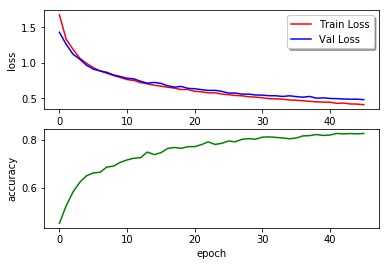

EPOCH: 47
TRAIN LOSS: 0.4125317380410085
VAL LOSS: 0.4787004636628608
VAL ACCURACY: 82.8 %
TIME: 27.6 s


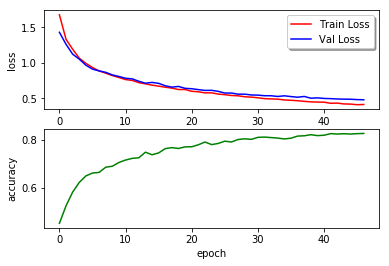

EPOCH: 48
TRAIN LOSS: 0.4042037591037569
VAL LOSS: 0.47261569362287414
VAL ACCURACY: 83.0 %
TIME: 27.7 s


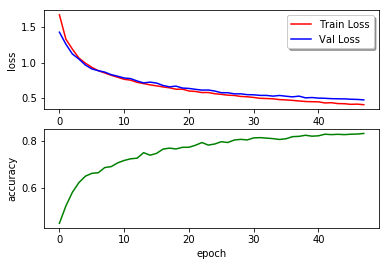

EPOCH: 49
TRAIN LOSS: 0.401338745357974
VAL LOSS: 0.4694531628441417
VAL ACCURACY: 83.4 %
TIME: 27.4 s


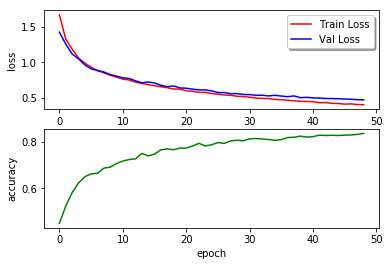

EPOCH: 50
TRAIN LOSS: 0.39889678350783125
VAL LOSS: 0.48344179634747486
VAL ACCURACY: 82.9 %
TIME: 27.5 s


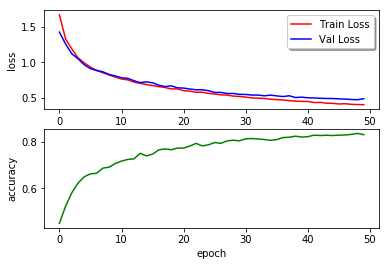

EPOCH: 51
TRAIN LOSS: 0.39660534894058774
VAL LOSS: 0.4673713040150975
VAL ACCURACY: 83.6 %
TIME: 27.7 s


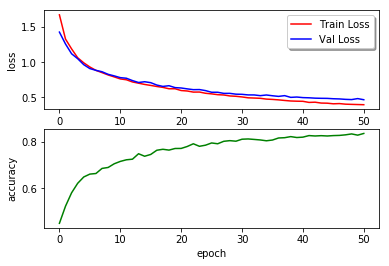

EPOCH: 52
TRAIN LOSS: 0.38835246879109164
VAL LOSS: 0.47042458579946295
VAL ACCURACY: 83.6 %
TIME: 27.8 s


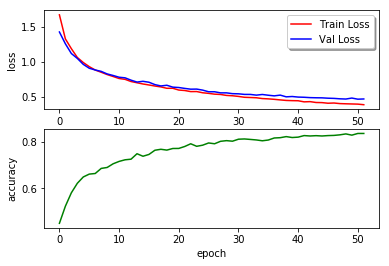

EPOCH: 53
TRAIN LOSS: 0.3816660107700589
VAL LOSS: 0.47434836446322937
VAL ACCURACY: 83.5 %
TIME: 28.0 s


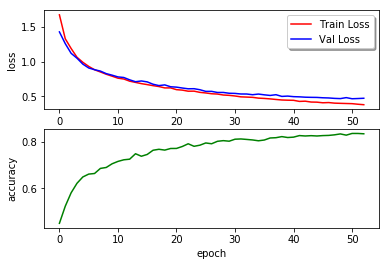

EPOCH: 54
TRAIN LOSS: 0.38021774315650264
VAL LOSS: 0.46589525630222123
VAL ACCURACY: 83.6 %
TIME: 28.1 s


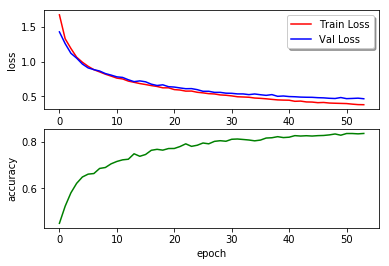

EPOCH: 55
TRAIN LOSS: 0.37309713653056115
VAL LOSS: 0.477558779149758
VAL ACCURACY: 83.4 %
TIME: 27.8 s


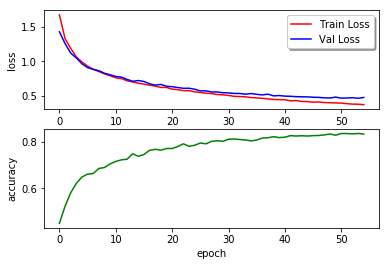

EPOCH: 56
TRAIN LOSS: 0.3766275500167912
VAL LOSS: 0.46538773623297913
VAL ACCURACY: 83.5 %
TIME: 28.0 s


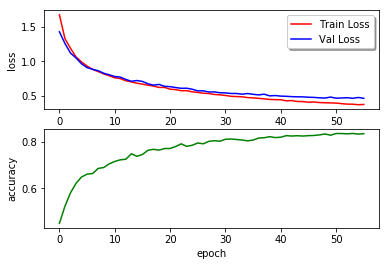

EPOCH: 57
TRAIN LOSS: 0.37085128853933497
VAL LOSS: 0.4651240920975766
VAL ACCURACY: 83.9 %
TIME: 27.8 s


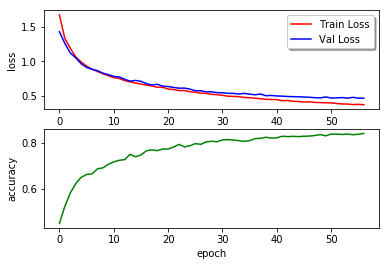

EPOCH: 58
TRAIN LOSS: 0.36728966314009565
VAL LOSS: 0.46126691029459
VAL ACCURACY: 84.1 %
TIME: 27.7 s


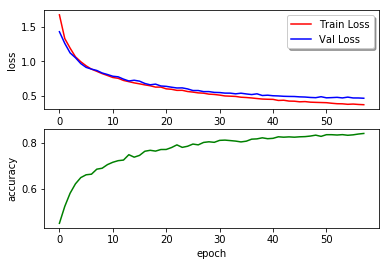

EPOCH: 59
TRAIN LOSS: 0.36519074179083194
VAL LOSS: 0.46150673136387876
VAL ACCURACY: 83.6 %
TIME: 28.1 s


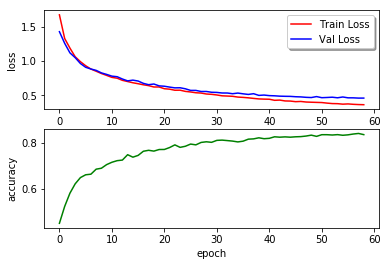

EPOCH: 60
TRAIN LOSS: 0.357335670627011
VAL LOSS: 0.46705863256527713
VAL ACCURACY: 83.8 %
TIME: 28.4 s


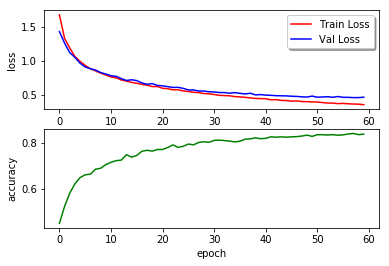

EPOCH: 61
TRAIN LOSS: 0.3512289654961751
VAL LOSS: 0.4575092462124704
VAL ACCURACY: 84.4 %
TIME: 29.1 s


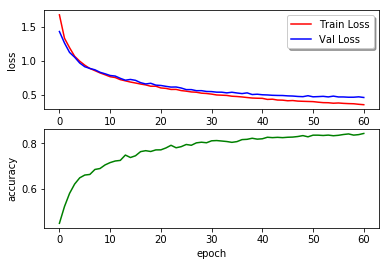

EPOCH: 62
TRAIN LOSS: 0.35404285069591485
VAL LOSS: 0.4473994033708826
VAL ACCURACY: 84.9 %
TIME: 28.1 s


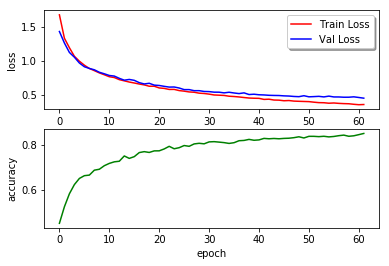

EPOCH: 63
TRAIN LOSS: 0.34606264837223877
VAL LOSS: 0.4475373822621012
VAL ACCURACY: 84.1 %
TIME: 28.2 s


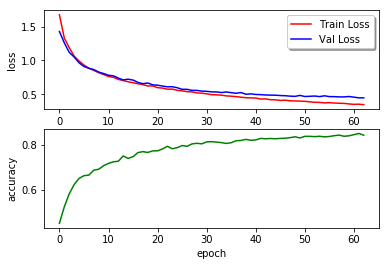

EPOCH: 64
TRAIN LOSS: 0.34577081557335637
VAL LOSS: 0.44496458962930485
VAL ACCURACY: 84.9 %
TIME: 28.1 s


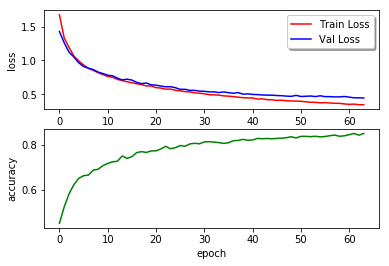

EPOCH: 65
TRAIN LOSS: 0.3403676122641661
VAL LOSS: 0.459442872732735
VAL ACCURACY: 84.1 %
TIME: 28.1 s


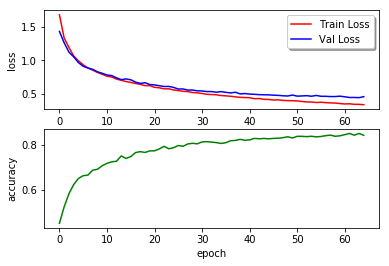

EPOCH: 66
TRAIN LOSS: 0.34216660578658886
VAL LOSS: 0.4531878728267814
VAL ACCURACY: 85.3 %
TIME: 27.9 s


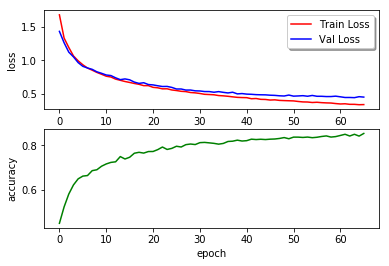

EPOCH: 67
TRAIN LOSS: 0.3337560860256302
VAL LOSS: 0.4534706303624118
VAL ACCURACY: 84.1 %
TIME: 28.0 s


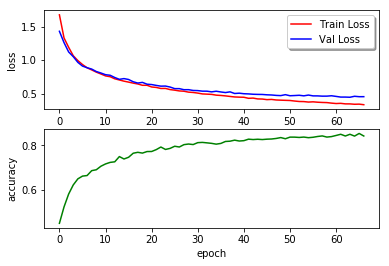

EPOCH: 68
TRAIN LOSS: 0.3328837146525257
VAL LOSS: 0.4502643664849288
VAL ACCURACY: 84.6 %
TIME: 28.3 s


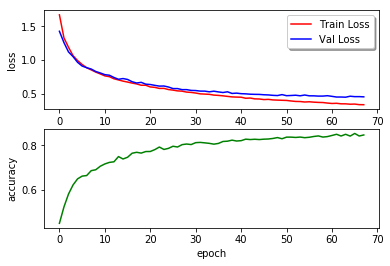

EPOCH: 69
TRAIN LOSS: 0.3333144766026406
VAL LOSS: 0.4503391735716185
VAL ACCURACY: 84.8 %
TIME: 28.3 s


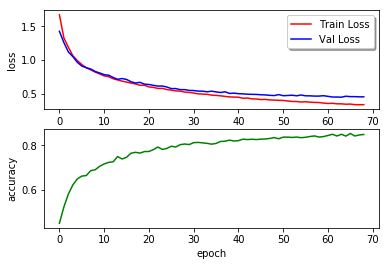

EPOCH: 70
TRAIN LOSS: 0.3234969101206875
VAL LOSS: 0.45160510762118083
VAL ACCURACY: 85.1 %
TIME: 28.1 s


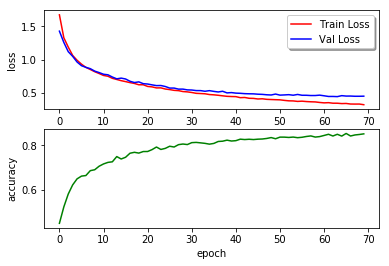

EPOCH: 71
TRAIN LOSS: 0.32305772325391785
VAL LOSS: 0.45003219967171265
VAL ACCURACY: 84.7 %
TIME: 28.4 s


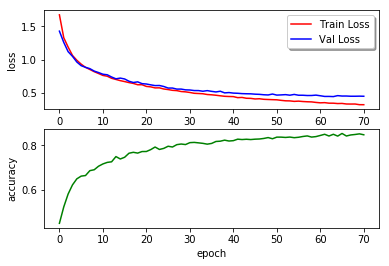

EPOCH: 72
TRAIN LOSS: 0.32217507939447226
VAL LOSS: 0.46142472765355147
VAL ACCURACY: 84.5 %
TIME: 28.0 s


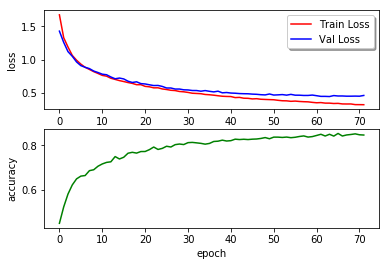

EPOCH: 73
TRAIN LOSS: 0.31564902037297077
VAL LOSS: 0.4477749625221834
VAL ACCURACY: 84.9 %
TIME: 28.5 s


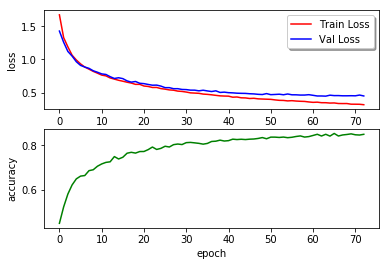

EPOCH: 74
TRAIN LOSS: 0.31524534929095815
VAL LOSS: 0.42399512854450816
VAL ACCURACY: 85.4 %
TIME: 44.6 s


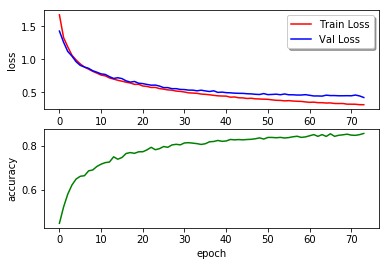

EPOCH: 75
TRAIN LOSS: 0.3090203201379898
VAL LOSS: 0.45547454760372
VAL ACCURACY: 84.7 %
TIME: 97.2 s


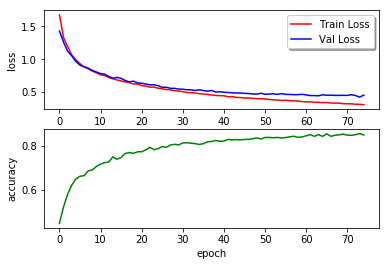

EPOCH: 76
TRAIN LOSS: 0.3094903991341812
VAL LOSS: 0.4521923202085599
VAL ACCURACY: 84.9 %
TIME: 28.1 s


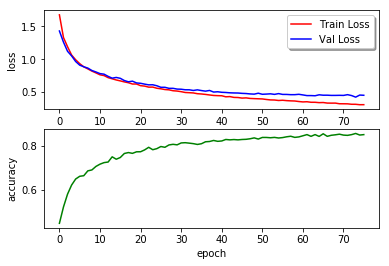

EPOCH: 77
TRAIN LOSS: 0.3108634737206603
VAL LOSS: 0.4609879607618269
VAL ACCURACY: 84.9 %
TIME: 27.9 s


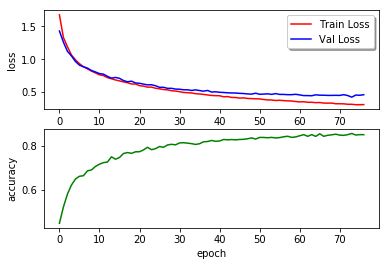

EPOCH: 78
TRAIN LOSS: 0.30475969241832757
VAL LOSS: 0.4540022839569381
VAL ACCURACY: 85.1 %
TIME: 28.6 s


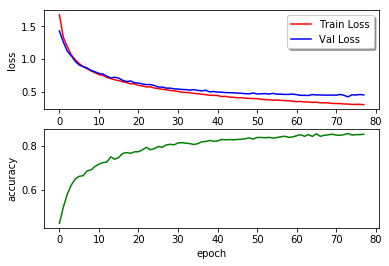

EPOCH: 79
TRAIN LOSS: 0.2976271237831915
VAL LOSS: 0.4499878115566912
VAL ACCURACY: 84.8 %
TIME: 28.0 s


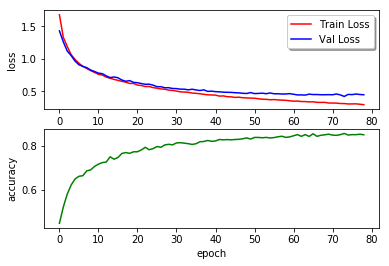

EPOCH: 80
TRAIN LOSS: 0.3008850433984246
VAL LOSS: 0.44979725108376595
VAL ACCURACY: 85.3 %
TIME: 28.2 s


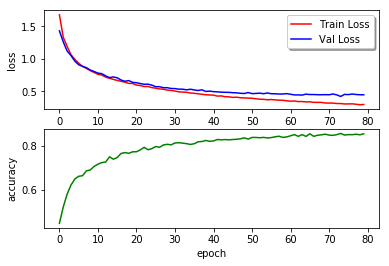

EPOCH: 81
TRAIN LOSS: 0.295428868369565
VAL LOSS: 0.4483861978697019
VAL ACCURACY: 84.9 %
TIME: 30.4 s


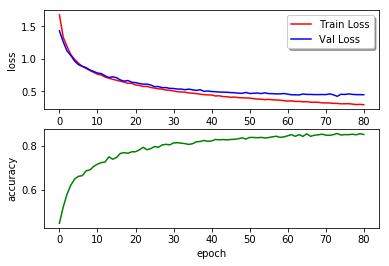

EPOCH: 82
TRAIN LOSS: 0.29740853351605534
VAL LOSS: 0.45194022976826037
VAL ACCURACY: 85.1 %
TIME: 29.1 s


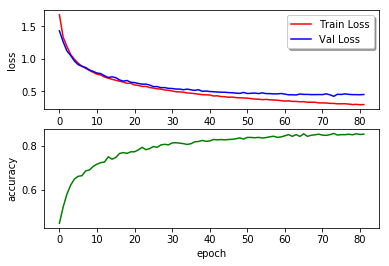

EPOCH: 83
TRAIN LOSS: 0.28439292545194783
VAL LOSS: 0.45831059404509844
VAL ACCURACY: 85.0 %
TIME: 30.6 s


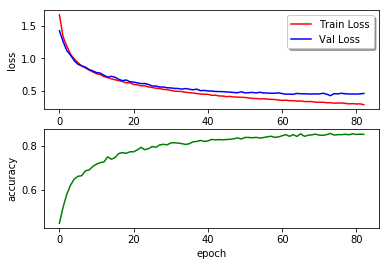

EPOCH: 84
TRAIN LOSS: 0.28644365427484003
VAL LOSS: 0.4645161949309711
VAL ACCURACY: 85.1 %
TIME: 27.8 s


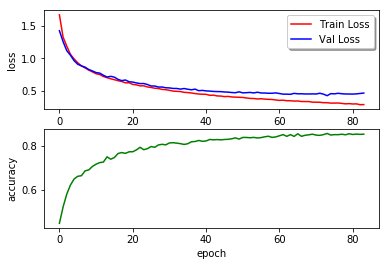

EPOCH: 85
TRAIN LOSS: 0.2837471892569298
VAL LOSS: 0.4481995391678095
VAL ACCURACY: 85.2 %
TIME: 27.7 s


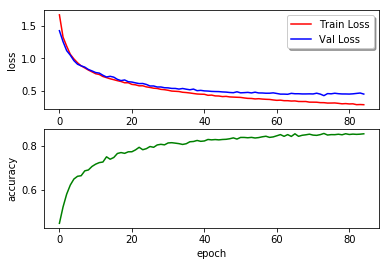

EPOCH: 86
TRAIN LOSS: 0.27735621791789566
VAL LOSS: 0.4566582289845681
VAL ACCURACY: 85.4 %
TIME: 28.6 s


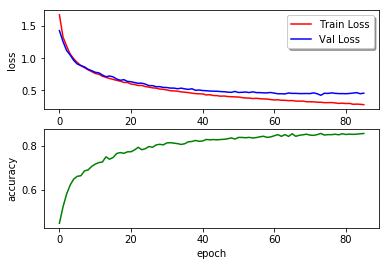

EPOCH: 87
TRAIN LOSS: 0.27387049627673893
VAL LOSS: 0.4689652553836303
VAL ACCURACY: 85.1 %
TIME: 29.1 s


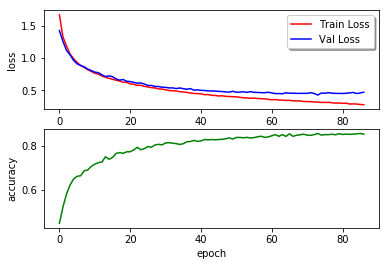

EPOCH: 88
TRAIN LOSS: 0.27347222534929766
VAL LOSS: 0.4675045882304405
VAL ACCURACY: 85.5 %
TIME: 30.1 s


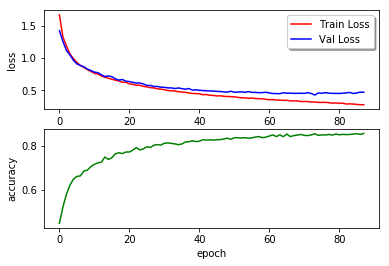

EPOCH: 89
TRAIN LOSS: 0.2686901756072103
VAL LOSS: 0.4582384933837527
VAL ACCURACY: 84.5 %
TIME: 27.9 s


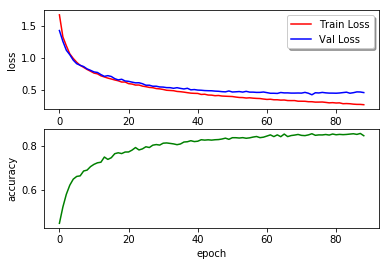

EPOCH: 90
TRAIN LOSS: 0.25974795422228836
VAL LOSS: 0.4653988669387674
VAL ACCURACY: 85.5 %
TIME: 28.6 s


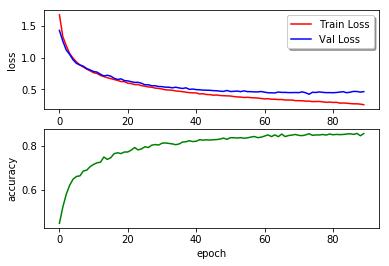

EPOCH: 91
TRAIN LOSS: 0.25678542167357116
VAL LOSS: 0.46575280495998217
VAL ACCURACY: 85.2 %
TIME: 27.9 s


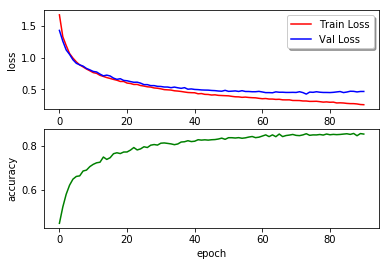

EPOCH: 92
TRAIN LOSS: 0.258106916924642
VAL LOSS: 0.47795091722332766
VAL ACCURACY: 85.1 %
TIME: 27.4 s


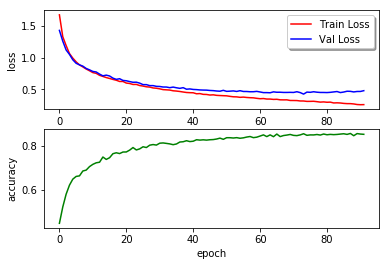

EPOCH: 93
TRAIN LOSS: 0.2527714349132505
VAL LOSS: 0.46276631044043526
VAL ACCURACY: 84.7 %
TIME: 27.5 s


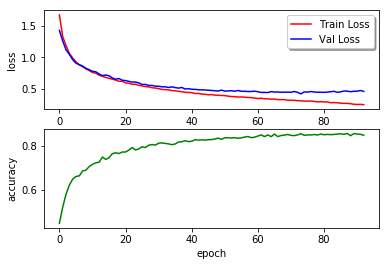

EPOCH: 94
TRAIN LOSS: 0.24944798638021842
VAL LOSS: 0.4893258050110172
VAL ACCURACY: 84.5 %
TIME: 27.6 s


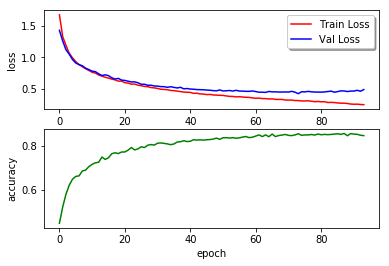

EPOCH: 95
TRAIN LOSS: 0.24545463875601303
VAL LOSS: 0.47217993544893055
VAL ACCURACY: 84.6 %
TIME: 28.1 s


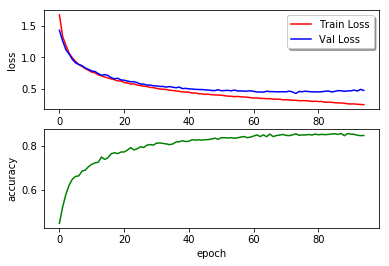

EPOCH: 96
TRAIN LOSS: 0.2378671809652505
VAL LOSS: 0.47574225526265884
VAL ACCURACY: 85.2 %
TIME: 27.7 s


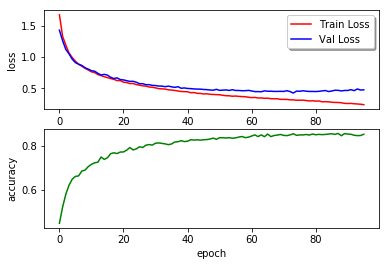

EPOCH: 97
TRAIN LOSS: 0.24054083135741205
VAL LOSS: 0.49518143771920836
VAL ACCURACY: 84.9 %
TIME: 27.7 s


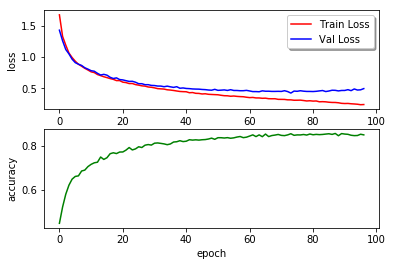

EPOCH: 98
TRAIN LOSS: 0.23520266934956421
VAL LOSS: 0.5035431167698676
VAL ACCURACY: 84.9 %
TIME: 27.8 s


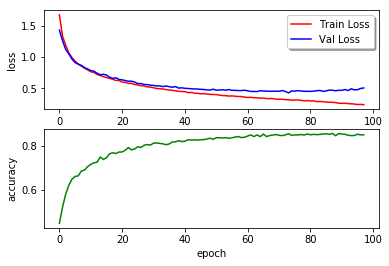

EPOCH: 99
TRAIN LOSS: 0.23472515908905653
VAL LOSS: 0.48632715646201635
VAL ACCURACY: 85.1 %
TIME: 28.8 s


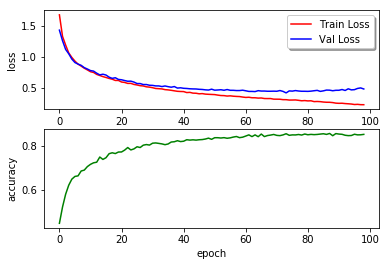

EPOCH: 100
TRAIN LOSS: 0.22965278258737742
VAL LOSS: 0.49258215700067454
VAL ACCURACY: 84.5 %
TIME: 27.8 s


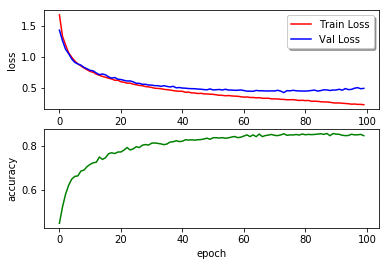

EPOCH: 101
TRAIN LOSS: 0.22475865281908686
VAL LOSS: 0.47965656075780305
VAL ACCURACY: 84.9 %
TIME: 27.8 s


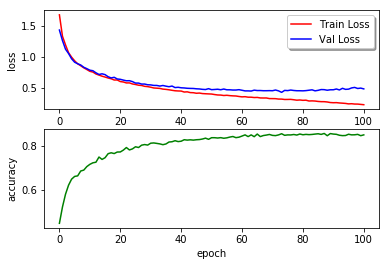

EPOCH: 102
TRAIN LOSS: 0.22189934698208236
VAL LOSS: 0.49464895811302806
VAL ACCURACY: 85.9 %
TIME: 27.7 s


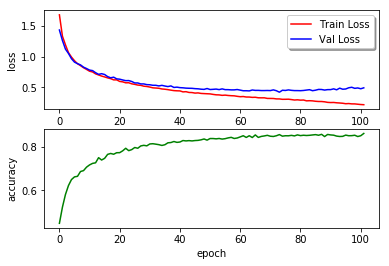

EPOCH: 103
TRAIN LOSS: 0.21972073864267458
VAL LOSS: 0.49390236684763117
VAL ACCURACY: 84.8 %
TIME: 28.2 s


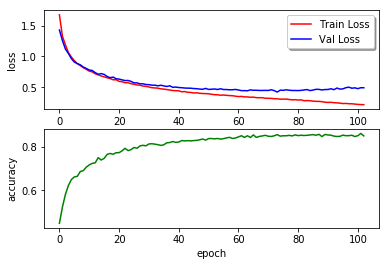

EPOCH: 104
TRAIN LOSS: 0.22029345421226834
VAL LOSS: 0.4933799223859594
VAL ACCURACY: 85.0 %
TIME: 28.2 s


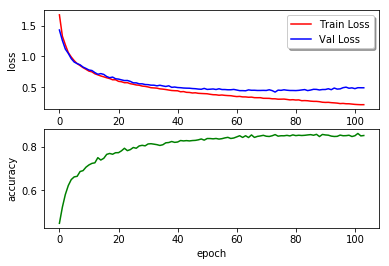

EPOCH: 105
TRAIN LOSS: 0.21277782900087577
VAL LOSS: 0.5098109828564547
VAL ACCURACY: 84.7 %
TIME: 28.2 s


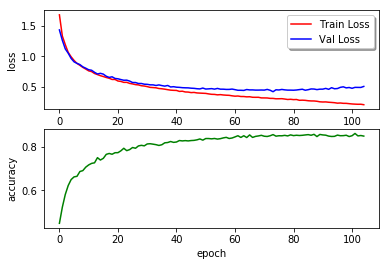

EPOCH: 106
TRAIN LOSS: 0.21236665889350181
VAL LOSS: 0.5075201718797722
VAL ACCURACY: 84.7 %
TIME: 28.0 s


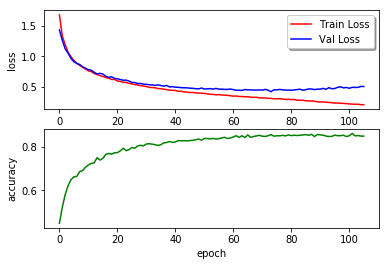

EPOCH: 107
TRAIN LOSS: 0.20687751839110774
VAL LOSS: 0.5095727732821459
VAL ACCURACY: 84.9 %
TIME: 27.9 s


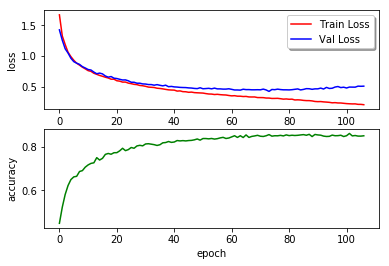

EPOCH: 108
TRAIN LOSS: 0.20186803521865404
VAL LOSS: 0.526539026703482
VAL ACCURACY: 85.4 %
TIME: 28.5 s


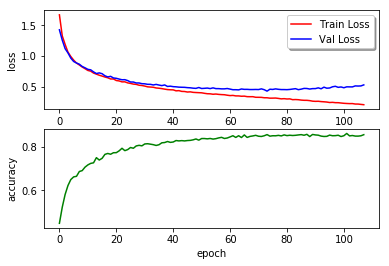

EPOCH: 109
TRAIN LOSS: 0.20207690098389502
VAL LOSS: 0.5059496243036992
VAL ACCURACY: 85.2 %
TIME: 28.3 s


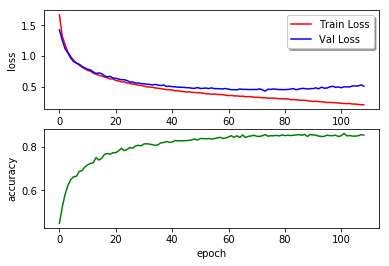

EPOCH: 110
TRAIN LOSS: 0.19953211475290974
VAL LOSS: 0.5423508876869766
VAL ACCURACY: 85.0 %
TIME: 27.7 s


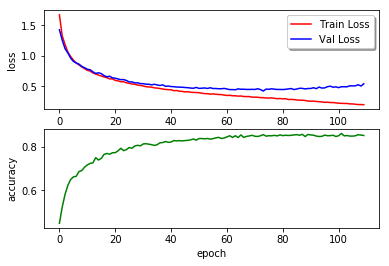

EPOCH: 111
TRAIN LOSS: 0.19886156033077118
VAL LOSS: 0.5405651315614969
VAL ACCURACY: 84.5 %
TIME: 29.1 s


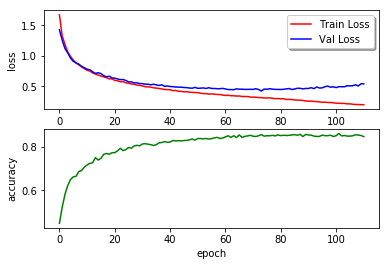

EPOCH: 112
TRAIN LOSS: 0.19316995210308144
VAL LOSS: 0.5356648940141322
VAL ACCURACY: 85.0 %
TIME: 29.4 s


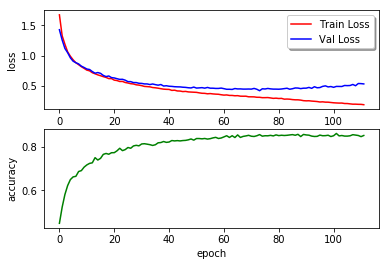

EPOCH: 113
TRAIN LOSS: 0.19369833269997333
VAL LOSS: 0.5532493864882745
VAL ACCURACY: 84.7 %
TIME: 28.8 s


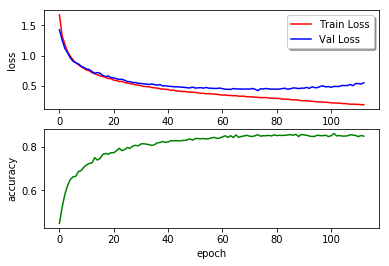

KeyboardInterrupt: 

In [13]:
import time
import sklearn
import numpy 
###################### TRAINING #########################
print ("START TRAINING...")
train_loss = []
val_loss = []
val_accuracy = []
for epoch in range(1,150):
 
    #start timer
    start = time.time()
 
    #iterate over train split batches and calculate mean loss for epoch
    t_l = []
    for image_batch, target_batch in getNextImageBatch():
 
        #calling the training functions returns the current loss
        l = train_net(image_batch, target_batch)
        t_l.append(l)
 
    #we validate our net every epoch and pass our validation split through as well
    v_l = []
    v_a = []
    for image_batch, target_batch in getNextImageBatch(VAL):
  
        #calling the test function returns the net output, loss and accuracy
        prediction_batch, l, a = test_net(image_batch, target_batch)
        v_l.append(l)
        v_a.append(a)
 
    #stop timer
    end = time.time()
 
    #calculate stats for epoch
    train_loss.append(np.mean(t_l))
    val_loss.append(np.mean(v_l))
    val_accuracy.append(np.mean(v_a))
 
    #print stats for epoch
    print ("EPOCH:", epoch,)
    print ("TRAIN LOSS:", train_loss[-1],)
    print ("VAL LOSS:", val_loss[-1],)
    print ("VAL ACCURACY:", (int(val_accuracy[-1] * 1000) / 10.0), "%",)
    print ("TIME:", (int((end - start) * 10) / 10.0), "s")
 
    #show chart
    showChart(epoch, train_loss, val_loss, val_accuracy)
 
print ("TRAINING DONE!") 

In [12]:
import matplotlib.pyplot as plt
 
##################### STAT PLOT #########################
plt.ion()
def showChart(epoch, t, v, a):
 
    #new figure
    plt.figure(0)
    plt.clf()
 
    #x-Axis = epoch
    e = range(0, epoch)
 
    #loss subplot
    plt.subplot(211)
    plt.plot(e, train_loss, 'r-', label='Train Loss')
    plt.plot(e, val_loss, 'b-', label='Val Loss')
    plt.ylabel('loss')
 
    #show labels
    plt.legend(loc='upper right', shadow=True)
 
    #accuracy subplot
    plt.subplot(212)
    plt.plot(e, val_accuracy, 'g-')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
 
    #show
    plt.show()
    plt.pause(0.5)

TypeError: Invalid dimensions for image data

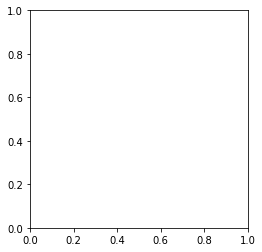

In [70]:
from sklearn.metrics import confusion_matrix
import itertools
 
################## CONFUSION MATRIX #####################
cmatrix = []
def clearConfusionMatrix():
 
    global cmatrix
 
    #allocate empty matrix of size 5x5 (for our 5 classes)
    cmatrix = np.zeros((len(CLASSES), len(CLASSES)), dtype='int32')
 

def updateConfusionMatrix(p, t):
 
    global cmatrix
    cmatrix += confusion_matrix(np.argmax(t, axis=1), np.argmax(p, axis=1))
 
def showConfusionMatrix():
 
    #new figure
    plt.figure(1)
    plt.clf()
 
    #show matrix
    plt.imshow(cmatrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
 
    #tick marks
    tick_marks = np.arange(len(CLASSES))
    plt.xticks(tick_marks, CLASSES)
    plt.yticks(tick_marks, CLASSES)
 
    #labels
    thresh = cmatrix.max() / 2.
    for i, j in itertools.product(range(cmatrix.shape[0]), range(cmatrix.shape[1])):
        plt.text(j, i, cmatrix[i, j], 
                 horizontalalignment="center",
                 color="white" if cmatrix[i, j] > thresh else "black")
 
    #axes labels
    plt.ylabel('Target label')
    plt.xlabel('Predicted label')
 
    #show
    plt.show()
    plt.pause(0.5)
    
showConfusionMatrix()
